## Meteogram Demo

First, import necessary libraries - pandas (for reading/manipulating data) and matplotlib

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

Read the csv containing the data - these are parsed metar observations from KPHL on the derecho day (June 3 2020)

In [2]:
df = pd.read_csv('KPHL.csv', parse_dates=['time']) # tell pandas to treat the time column as datetime
df = df.set_index('time') # for timeseries, it's often useful to set the timestamp as the "index" column in pandas
df

,temp_f,dew_f,wind_speed_kt,wind_gust_kt,wind_dir_deg,slp_mb,cloud_total_pct,precip_1hr_in
time,,,,,,,,
2020-06-03 00:00:00,71.60,46.40,5.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:05:00,71.60,46.40,7.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:10:00,69.80,46.40,8.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:15:00,71.60,46.40,7.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:20:00,69.80,46.40,8.0,NaN,230.0,NaN,100.0,NaN
...,...,...,...,...,...,...,...,...
2020-06-03 23:45:00,64.94,64.04,11.0,35.0,360.0,NaN,100.0,0.45
2020-06-03 23:50:00,66.20,64.40,11.0,NaN,340.0,NaN,75.0,NaN
2020-06-03 23:54:00,68.00,64.94,11.0,NaN,360.0,1005.0,100.0,0.51


### Plotting

Simple example of plotting temperature only

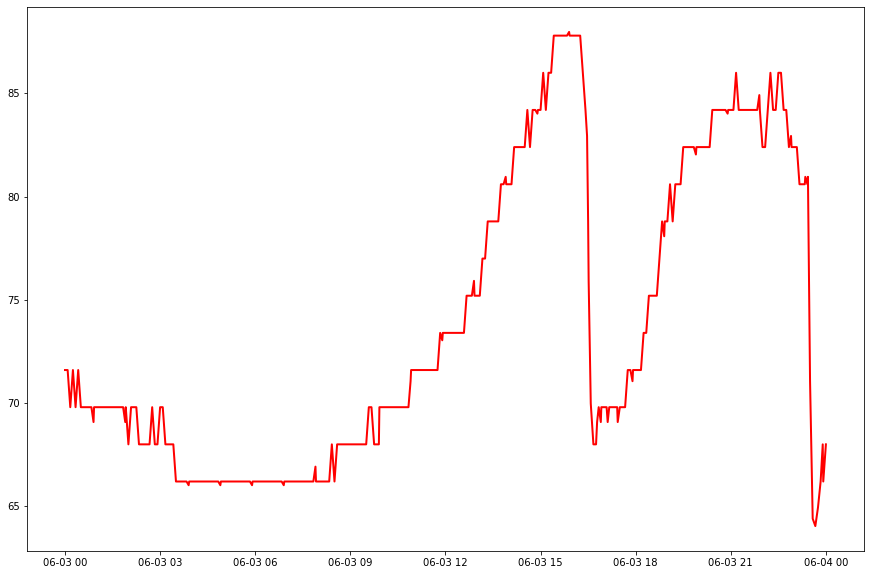

In [3]:
# Setting up the matplotlib figure
fig = plt.figure(figsize=(15,10)) # figure size in inches (weird, I know)
ax = fig.add_subplot(111) # creating a single axes that fills the whole figure window

# Plot temperatures
ax.plot(df.index, df['temp_f'], color='red', linewidth=2)

Since most of the observations are taken to the nearest degree celsius (only hourlies are not rounded), the lines are not very appealing to look at. I smooth the line by plotting a running mean of temepratures using pandas.dataframe.rolling.

Text(0.0, 1.0, 'A nicer-looking meteogram')

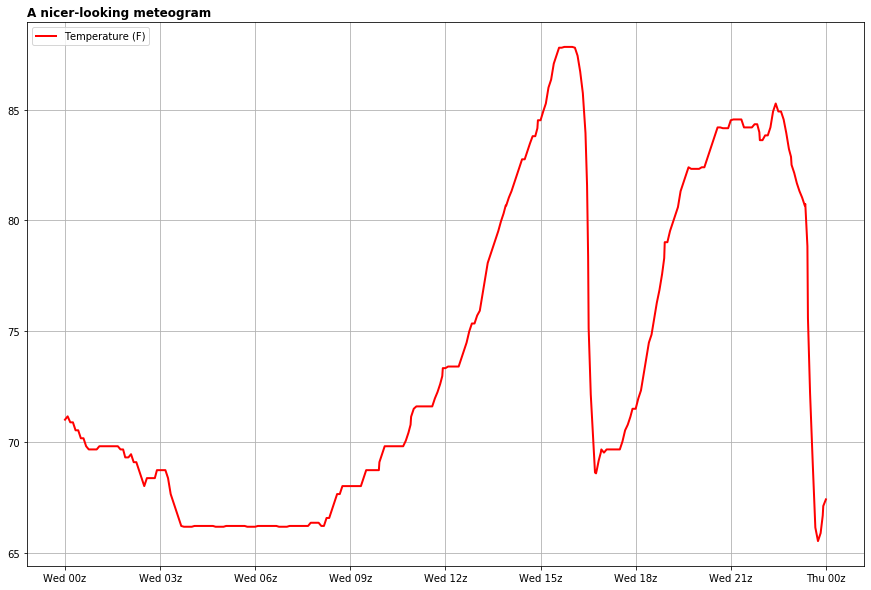

In [4]:
# Setting up the matplotlib figure
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

# Plot temperatures
smoothed = df['temp_f'].rolling(5, center=True, min_periods=1).mean() # See pandas documentation for more about this
# I set size of rolling window based on what looks good without losing too much information
p = ax.plot(df.index, smoothed, color='red', linewidth=2, label='Temperature (F)') # get handle for legend
ax.grid() # add some grid lines

# Format the dates to make them look nice
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %Hz'))

# Add a legend
plt.legend(handles=(p), loc='upper left')

# A title
plt.title('A nicer-looking meteogram', fontweight='bold', loc='left')

### Fancy meteogram

We want to be able to plot multiple lines on the same plot, so we will make use of multiple axes. Below is a more-complicated example of making a meteogram.

Text(1.0, 1.0, '$\\bf{Valid}$: 00z Wed Jun 03 to 00z Thu Jun 04 2020')

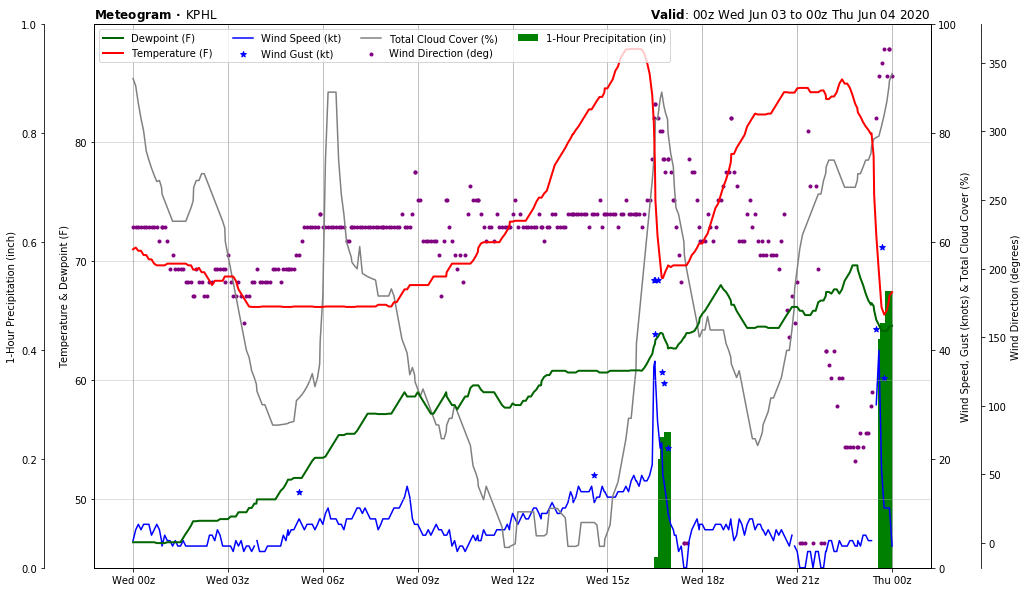

In [5]:
# Define some vars
station = 'KPHL'
start = pd.to_datetime(df.index[0])
end = pd.to_datetime(df.index[-1])

# Set up figure
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

# First plot precip bars. Since zorder does not work with multiple axes, begin with "bottom" bars/lines
ax.set_ylim(0,1)
p1 = ax.bar(df.index, df['precip_1hr_in'], width=0.01, color='green', label='1-Hour Precipitation (in)')
ax.set_ylabel('1-Hour Precipitation (inch)')
ax.spines['left'].set_position(('outward', 50)) # Control position of axis/labels
ax.grid(axis='x') # time gridlines

# Create a second axis for plotting wind direction
ax2 = ax.twinx()
p2 = ax2.scatter(df.index, df['wind_dir_deg'], marker='.', color='purple', label='Wind Direction (deg)')
ax2.set_ylabel('Wind Direction (degrees)')
ax2.spines['right'].set_position(('outward', 50))

# Yet another axis for wind speed, gust, and total cloud
# I decided to group these together as they have similar y-ranges 
ax3 = ax.twinx()
ax3.set_ylim(0,100)
p3, = ax3.plot(df.index, df['wind_speed_kt'], color='blue', label='Wind Speed (kt)')
p4 = ax3.scatter(df.index, df['wind_gust_kt'], marker='*', color='blue', label='Wind Gust (kt)')
p5, = ax3.plot(df.index, df['cloud_total_pct'].rolling(20, min_periods=1, center=True).mean(), color='grey', label='Total Cloud Cover (%)')
ax3.set_ylabel('Wind Speed, Gust (knots) & Total Cloud Cover (%)')

# Temprature and dewpoint
ax4 = ax.twinx()
p6, = ax4.plot(df.index, df['temp_f'].rolling(5, min_periods=1, center=True).mean(), color='red', linewidth=2, label='Temperature (F)')
p7, = ax4.plot(df.index, df['dew_f'].rolling(5, min_periods=1, center=True).mean(), color='darkgreen', linewidth=2, label='Dewpoint (F)')
ax4.set_ylabel('Temperature & Dewpoint (F)')
ax4.yaxis.set_ticks_position('left')
ax4.yaxis.set_label_position('left')
ax4.grid(alpha=0.5)

# Legend and titles
plt.legend(handles=(p7,p6,p3,p4,p5,p2,p1), loc='upper left', ncol=4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %Hz'))
plt.title(r"$\bf{Meteogram\/\cdot\/}$"+station, loc='left')
plt.title(r"$\bf{Valid}$"+': '+datetime.strftime(start, '%Hz %a %b %d to ')+datetime.strftime(end, '%Hz %a %b %d %Y'), loc='right')

## Task

There's a lot going on in the meteogram above. I think it would look better as a multi-panel plot, with only 2 y-axes per panel. For example, the top panel could be temperature & dewpoint, along with wind speed, direction, and gust (could consider plotting wind barbs instead of the direction in degrees). A bottom panel could have sea level pressure, cloud cover, and precip. You can use your best judgement to determine what looks good - I try to use a mix of bars, lines, and points to give variety w/appropriate colors. 

Text(0.5, 1, '2-panel meteogram layout')

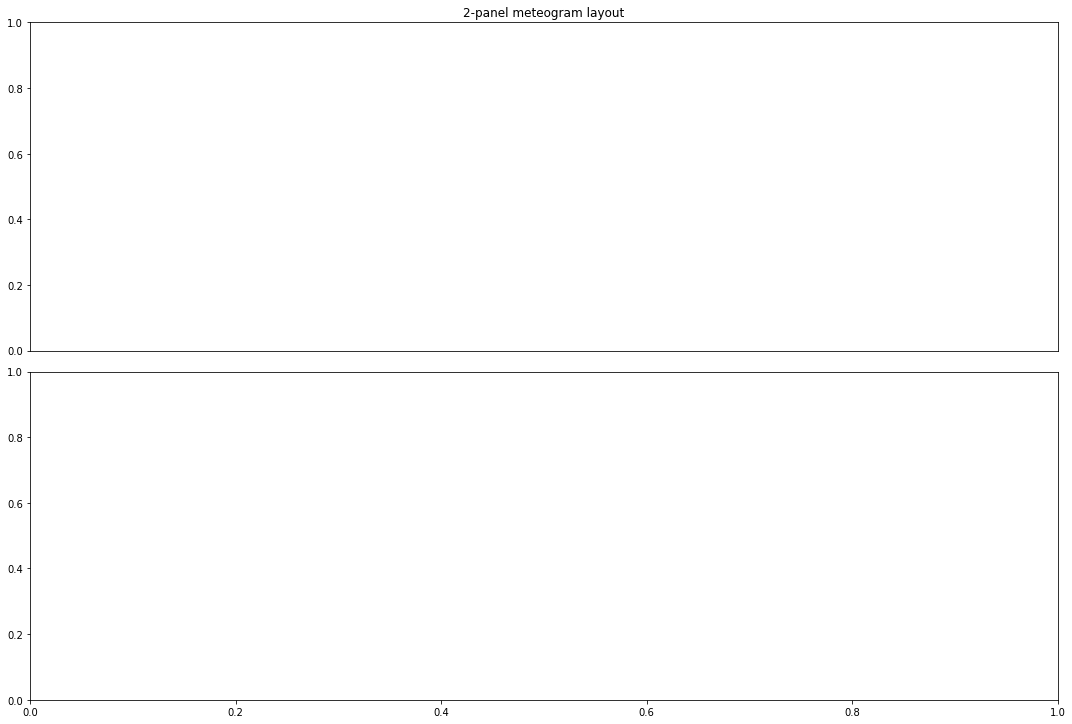

In [6]:
# Example of a subplot layout you can use

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax.get_xaxis().set_visible(False) # Since the x-axis will be shared, no need for tick labels
ax2 = fig.add_subplot(212, sharex=ax)
plt.tight_layout() # Remove unnecessary white space between panels
ax.set_title('2-panel meteogram layout') # Reference the first axis as this panel needs to be on top